In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
datasets = ['Erasmus14.csv', 'Erasmus15.csv', 'Erasmus16.csv', 'Erasmus17.csv', 'Erasmus18.csv', 'Erasmus19.csv']
#local_dir = r"C:\Users\nicol\OneDrive\Desktop\scuola\NETWORK SCIENCE\progetto\data\\"
local_dir = "data/"

mobility_df = pd.read_csv(local_dir + datasets[0], sep=';',low_memory=False, header=0)
for i in range(1, len(datasets)):
    mobility_df = pd.concat([mobility_df, pd.read_csv(local_dir + datasets[i], sep=';',low_memory=False, header=0)], axis=0)

In [3]:
def filter_data(df):
    df= df[df['Participant Profile']=='Learner']
    df= df[df['Activity (mob)'].str.contains('Student')]
    df = df[~df['Activity (mob)'].str.contains('traineeship')]
    df = df.loc[:, ['Sending Country Code', 'Sending Organization','Receiving Country Code', 'Receiving Organization',
                    'Participants', 'Sending City', 'Receiving City']]
    return df

mobility_df = filter_data(mobility_df)

mobility_df['Sending Organization'] = mobility_df['Sending Organization'].str.upper()
mobility_df['Receiving Organization'] = mobility_df['Receiving Organization'].str.upper()

In [4]:
mobility_df = mobility_df.drop(mobility_df[(mobility_df['Sending Country Code'] == 'IT')&(mobility_df['Receiving Country Code'] == 'IT')].index)
mobility_df = mobility_df.drop(mobility_df[(mobility_df['Sending Country Code'] != 'IT')&(mobility_df['Receiving Country Code'] != 'IT')].index)

from_italy = mobility_df[mobility_df['Sending Country Code'] == 'IT']
to_italy = mobility_df[mobility_df['Receiving Country Code'] == 'IT']

mobility_df = pd.concat((from_italy, to_italy))

print('Number of Italian Receiving Universities: ',(to_italy['Receiving Organization'].nunique()))
print('Number of Italian Sending Universities: ',(from_italy['Sending Organization'].nunique()))

Number of Italian Receiving Universities:  241
Number of Italian Sending Universities:  220


In [5]:
italian_nodes = np.array(list(set.union(set(from_italy.loc[:, 'Sending Organization']), set(to_italy.loc[:, 'Receiving Organization']))))
number_of_italian_node = len(italian_nodes)
print('Number of italian universities', number_of_italian_node)
not_italian_nodes = np.array(list(set.union(set(to_italy.loc[:, 'Sending Organization']), set(from_italy.loc[:, 'Receiving Organization']))))
nodes = np.concatenate((italian_nodes, not_italian_nodes))
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))

Number of italian universities 275


In [6]:
mobility_df = mobility_df.drop(mobility_df[(mobility_df['SendId']>number_of_italian_node) & (mobility_df['RecId']>number_of_italian_node)].index)

In [7]:
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

# cercasi 70 Gb di ram, no perditempo
#ns.visualize_adj(adj_matrix_crs)

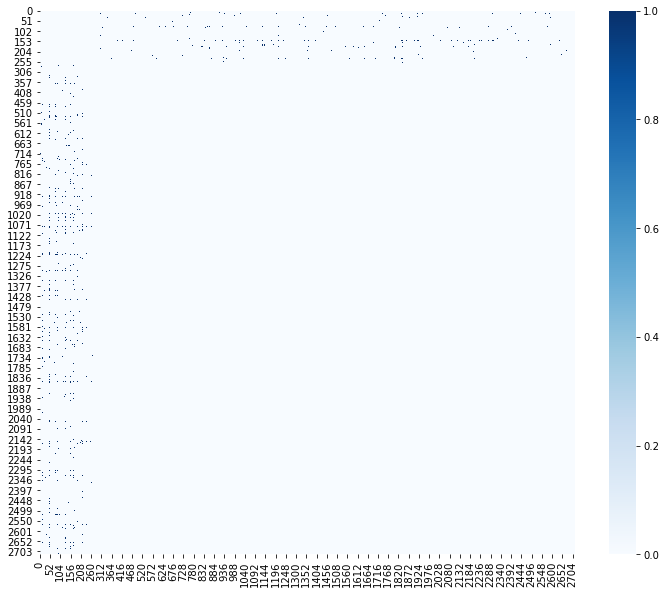

In [8]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
a_adj = adj_matrix_crs.toarray()
a_adj[a_adj>1] = 1
sns.heatmap(a_adj, cmap="Blues", ax=ax)
plt.show()

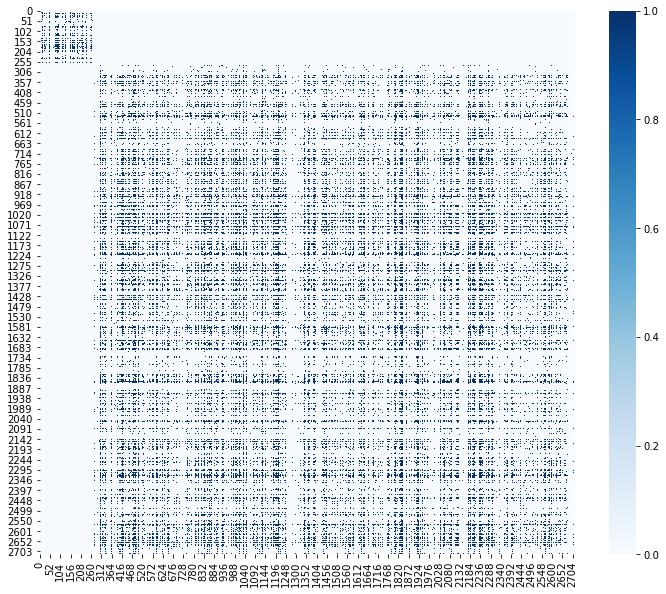

In [9]:
projection = adj_matrix_crs**2
fig, ax = plt.subplots(1,1,figsize=(12,10))
a_adj = projection.toarray()
a_adj[a_adj>1] = 1
sns.heatmap(a_adj, cmap="Blues", ax=ax)
plt.show()

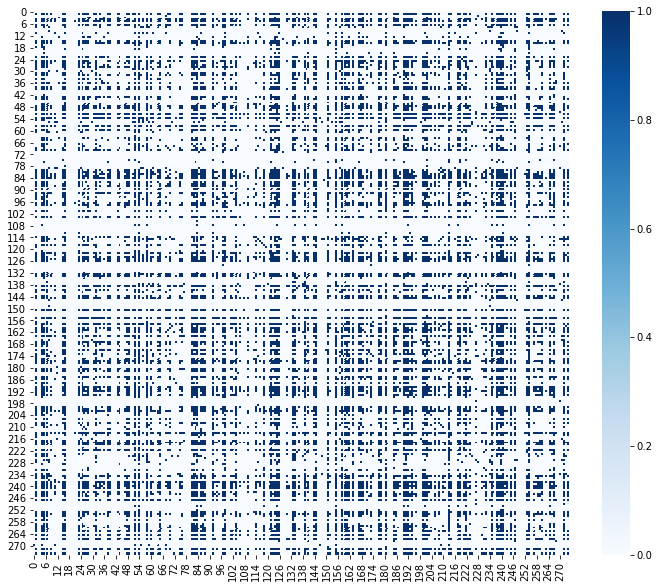

In [10]:
italian_matrix = projection[0:number_of_italian_node, 0:number_of_italian_node]
fig, ax = plt.subplots(1,1,figsize=(12,10))
a_adj = italian_matrix.toarray()
a_adj[a_adj>1] = 1
sns.heatmap(a_adj, cmap="Blues", ax=ax)
plt.show()

In [11]:
italian_df = pd.DataFrame(italian_nodes, columns=['Sending Organization'])
italian_df['SendId'] = (np.array(list(map(lambda x: node_position[x], italian_df['Sending Organization']))))
italian_df2 = pd.DataFrame(italian_nodes, columns=['Receiving Organization'])
italian_df2['RecId'] = (np.array(list(map(lambda x: node_position[x], italian_df2['Receiving Organization']))))
italian_df = italian_df.merge(italian_df2, how='cross')
italian_df['Participants'] = np.nan

rows, columns = italian_matrix.nonzero()
for r,c in zip(rows, columns):
    italian_df.at[(italian_df['SendId'] == c) &(italian_df['RecId'] == r), 'Participants']= italian_matrix[r,c]

italian_df = italian_df.dropna()
italian_df

,Sending Organization,SendId,Receiving Organization,RecId,Participants
270,ISTITUTO STATALE SUPERIORE DI STUDI MUSICALI E...,0,CONSERVATORIO DI MUSICA DI PERUGIA,270,1.0
276,UNIVERSITA' DEGLI STUDI DI URBINO CARLO BO,1,UNIVERSITA' DEGLI STUDI DI URBINO CARLO BO,1,143.0
279,UNIVERSITA' DEGLI STUDI DI URBINO CARLO BO,1,UNIVERSITA DEGLI STUDI DI TRENTO,4,129.0
280,UNIVERSITA' DEGLI STUDI DI URBINO CARLO BO,1,UNIVERSITA DEGLI STUDI DI PALERMO,5,171.0
282,UNIVERSITA' DEGLI STUDI DI URBINO CARLO BO,1,UNIVERSITA DELLA CALABRIA,7,101.0
...,...,...,...,...,...
75613,LIBERA UNIVERSITA DI LINGUE E COMUNICAZIONE IULM,274,UNIVERSITÀ DEGLI STUDI INTERNAZIONALI DI ROMA,263,7.0
75615,LIBERA UNIVERSITA DI LINGUE E COMUNICAZIONE IULM,274,UNIVERSITA DEGLI STUDI MAGNA GRAECIA DI CATANZARO,265,10.0
75617,LIBERA UNIVERSITA DI LINGUE E COMUNICAZIONE IULM,274,UNIVERSITA POLITECNICA DELLE MARCHE,267,2.0
75622,LIBERA UNIVERSITA DI LINGUE E COMUNICAZIONE IULM,274,UNIVERSITA DEGLI STUDI DI SALERNO,272,51.0


In [12]:
uni_cities = mobility_df.copy()
mobility_df = italian_df
adj_matrix_crs = italian_matrix
nodes_df = pd.DataFrame({'Nodes': italian_nodes})

mobility_df.rename({'Sending Organization': 'source','Receiving Organization': 'target', 'Participants':'weight'},axis=1, inplace=True)

nodes_component = ns.find_components(adj_matrix_crs, nodes_df)
components_n = nodes_component.groupby(by=["component"]).count()
display(components_n)
for i in range(1, 12):
    print("component ", i )
    nodes_component_i = nodes_component[nodes_component['component'] == i]
    display(nodes_component_i)

,Nodes
component,
0,253
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1


component  1


,Nodes,component
6,"CONSERVATORIO DI MUSICA ""GESUALDO DA VENOSA""",1


component  2


,Nodes,component
22,"ACCADEMIA DI BELLE ARTI ""MARIO SIRONI""",2


component  3


,Nodes,component
40,CONSERVATORIO SAN PIETRO A MAJELLA,3


component  4


,Nodes,component
41,CONSERVATORIO STATALE DI MUSICA C. POLLINI - P...,4


component  5


,Nodes,component
45,CONSERVATORIO DI MUSICA ALFREDO CASELLA,5


component  6


,Nodes,component
53,RABAT SCHOOL OF GOVERNANCE AND ECONOMY (PRIVE),6


component  7


,Nodes,component
66,ACCADEMIA DI BELLE ARTI ALDO GALLI - I.L.E.M. SRL,7


component  8


,Nodes,component
89,ISTITUTO SUPERIORE DI STUDI MUSICALI 'CLAUDIO ...,8


component  9


,Nodes,component
91,UNIVERSITY OF ESSEX,9


component  10


,Nodes,component
107,INSTITUTO POLITÉCNICO DE CASTELO BRANCO,10


component  11


,Nodes,component
109,"CONSERVATORIO DI MUSICA ""A. VIVALDI""",11


In [13]:
adj_matrix_crs, mobility_df, nodes_df = ns.keep_giant(ns.find_components(adj_matrix_crs, nodes_df), mobility_df)

### Degree distribution

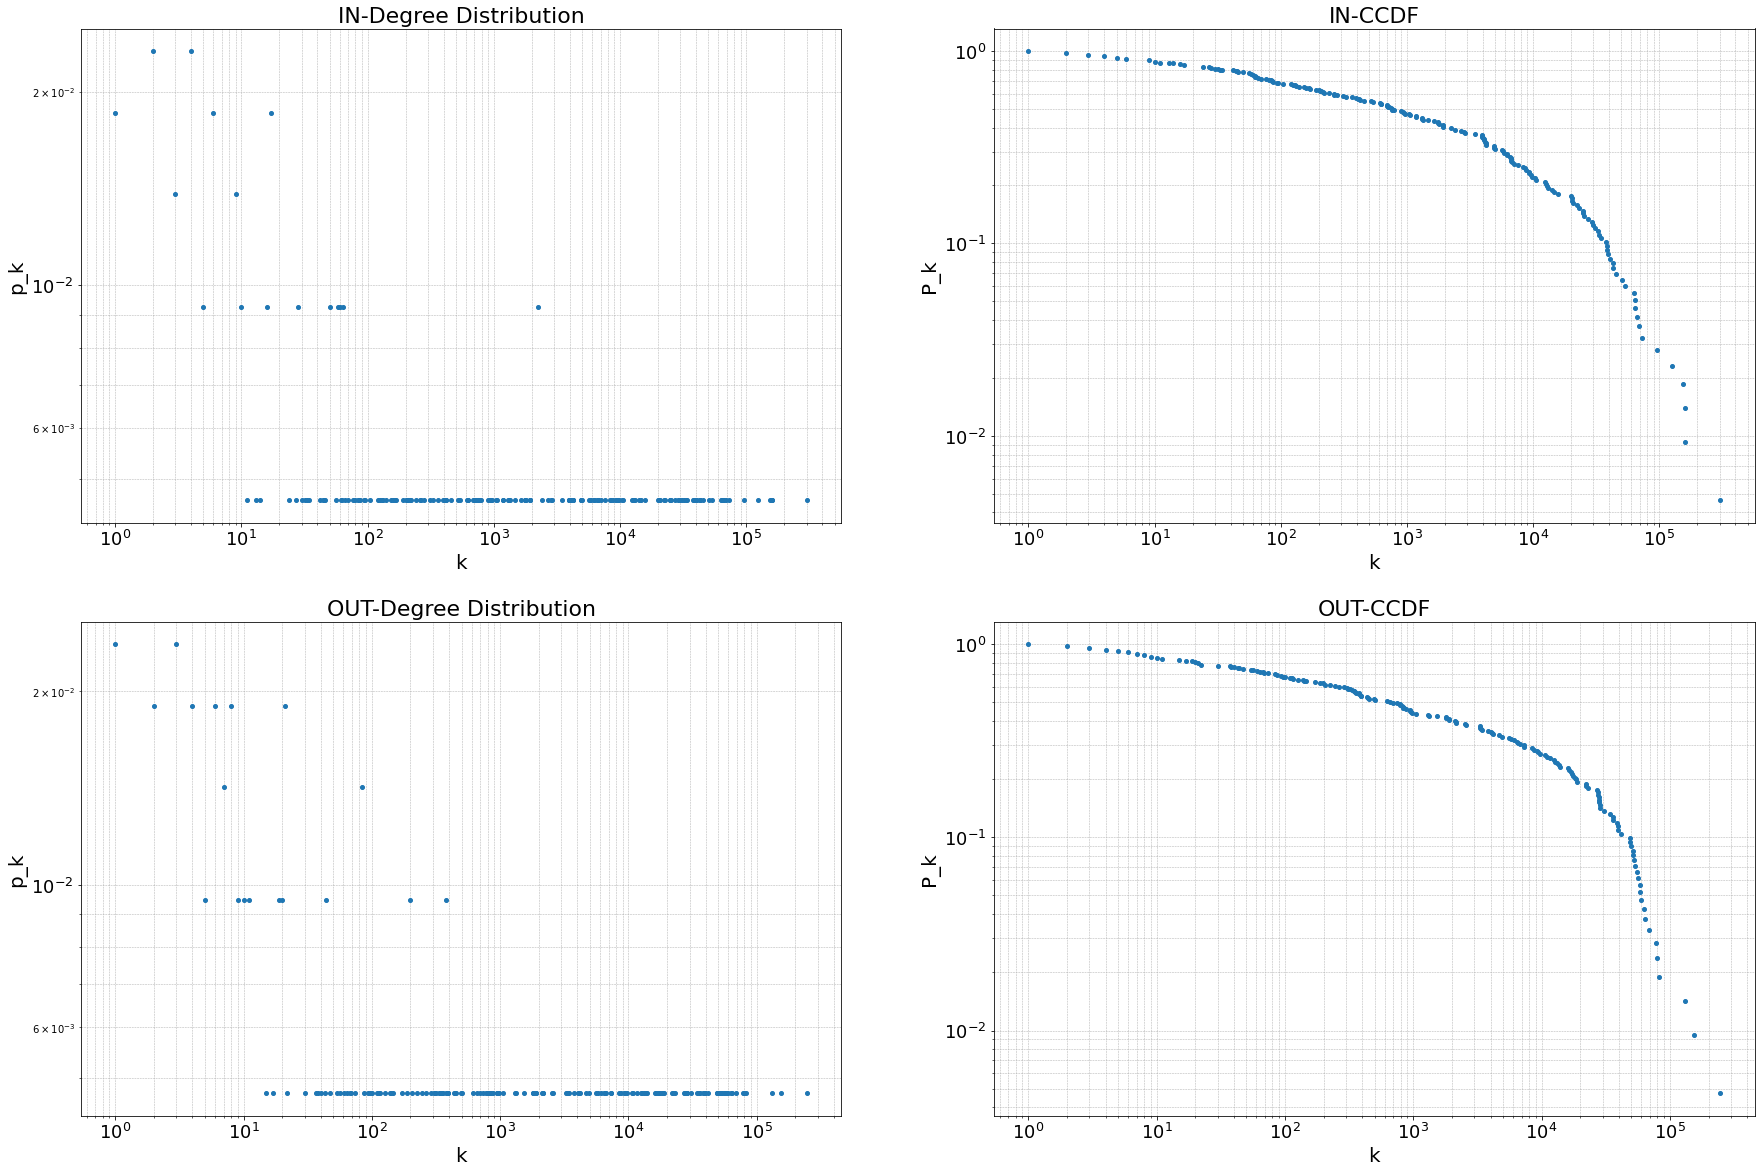

Top 10 for in degree


,Nodes,in degree
194,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,301706
184,POLITECNICO DI MILANO,160089
47,UNIVERSITA DEGLI STUDI DI PADOVA,159396
141,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,153476
219,UNIVERSITA DEGLI STUDI DI FIRENZE,124632
48,UNIVERSITA DEGLI STUDI DI TORINO,95062
158,UNIVERSITA COMMERCIALE LUIGI BOCCONI,73057
52,UNIVERSITA DEGLI STUDI DI MILANO,69468
200,POLITECNICO DI TORINO,66288
77,UNIVERSITA DEGLI STUDI ROMA TRE,64534


Top 10 for out degree


,Nodes,out degree
194,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,245660
48,UNIVERSITA DEGLI STUDI DI TORINO,153099
141,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,131231
47,UNIVERSITA DEGLI STUDI DI PADOVA,82361
52,UNIVERSITA DEGLI STUDI DI MILANO,79256
15,UNIVERSITA' DEGLI STUDI DI MILANO-BICOCCA,78029
184,POLITECNICO DI MILANO,68569
112,UNIVERSITA DEGLI STUDI DI SASSARI,64256
234,UNIVERSITA DEGLI STUDI DI NAPOLI FEDERICO II,63093
119,UNIVERSITA DEGLI STUDI DI TRIESTE,59143


In [14]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### Estimating $\gamma$ 

In [15]:
from collections import Counter
from statistics import mean

d_in = scores['in degree']
d_in = d_in[d_in>0]
d_out = scores['out degree']
d_out = d_out[d_out>0]
kmin = 1500
d2_in = d_in[d_in>kmin]
d2_out = d_out[d_out>kmin]

sorted_d = sorted(d_in)
occurrence = Counter(sorted_d)
x_in = list(occurrence.keys())
y_in = list(occurrence.values())
y_in = y_in/np.sum(y_in)

sorted_d = sorted(d_out)
occurrence = Counter(sorted_d)
x_out = list(occurrence.keys())
y_out = list(occurrence.values())
y_out = y_out/np.sum(y_out)

Pk_in = 1 - np.cumsum(y_in)
Pk_in[-1] = 1 
Pk_in = sorted(Pk_in, reverse = True)
Pk_out = 1 - np.cumsum(y_out)
Pk_out[-1] = 1 
Pk_out = sorted(Pk_out, reverse = True)

In [16]:
ga_in = 1 + 1/mean(np.array(np.log(d2_in/kmin)))
ga_out = 1 + 1/mean(np.array(np.log(d2_out/kmin)))
C_in = (ga_in-1)*kmin**(ga_in-1) # normalization condition
C_out = (ga_out-1)*kmin**(ga_out-1)

pos_in = np.argmax(np.array(x_in)>=kmin)
pos_out = np.argmax(np.array(x_out)>=kmin)

P_kmin_in = Pk_in[pos_in] # constant value that shifts the line where the data are placed
pk_in = C_in*P_kmin_in*x_in**-ga_in
Pk_est_in = C_in*P_kmin_in*x_in**(-(ga_in-1))/(ga_in-1) 

P_kmin_out = Pk_out[pos_out] # constant value that shifts the line where the data are placed
pk_out = C_out*P_kmin_out*x_out**-ga_out
Pk_est_out = C_out*P_kmin_out*x_out**(-(ga_out-1))/(ga_out-1) 

1.4701897037112337 1.429720479862956


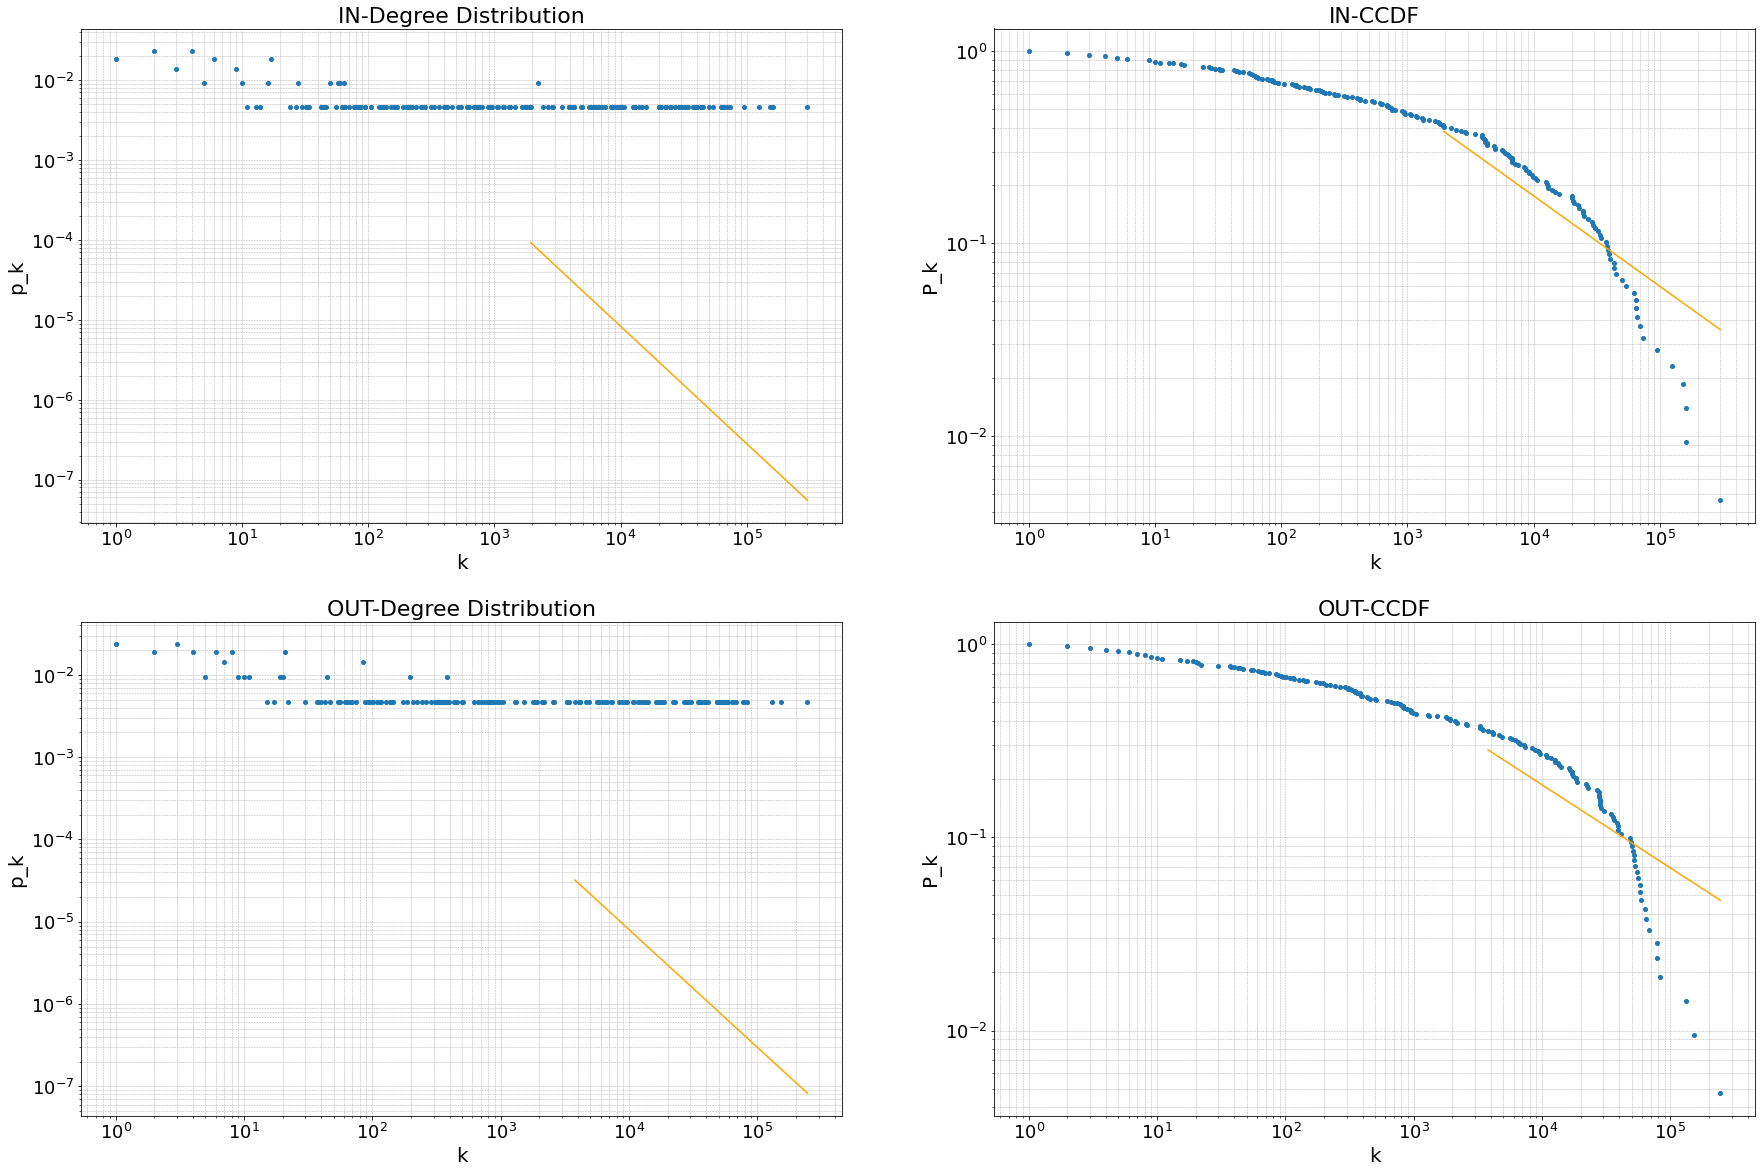

In [17]:
fig, ax = plt.subplots(2, 2, figsize = (30, 20))

def plot_gamma(ax, x, y, title, p, cumulative=False):
    ax.loglog(x, y, 'o', markersize = 4)
    idx = 100 
    ax.loglog(x[100:], p[100:], color='orange')
    ax.grid(which='both', linestyle='--', linewidth=0.5)
    ax.set_title(title, size = 22)
    ax.set_xlabel("k", size = 20)
    if cumulative:
        ax.set_ylabel("P_k", size = 20)
    else:
        ax.set_ylabel("p_k", size = 20)
    ax.tick_params(labelsize=18)
    ax.tick_params(labelsize=18)

plot_gamma(ax[0,0], x_in, y_in, "IN-Degree Distribution", pk_in)
plot_gamma(ax[0,1], x_in, Pk_in, "IN-CCDF", Pk_est_in, True)
plot_gamma(ax[1,0], x_out, y_out, "OUT-Degree Distribution", pk_out)
plot_gamma(ax[1,1], x_out, Pk_out, "OUT-CCDF", Pk_est_out, True)
print(ga_in, ga_out)
plt.show()

### Estimating $\gamma$ through a linear fit with log binning

In [18]:
# Log binning 
nbins = 20
bins = np.logspace(0, 3.3, nbins)

hist_in = np.histogram(d_in, bins=bins, density=True)
hist_out = np.histogram(d_out, bins=bins, density=True)
logbin_p_k_in = hist_in[0]
logbin_p_k_out = hist_out[0]
middle_bins = np.sqrt( np.delete(bins, 0) * np.delete(bins, nbins-1) )
kmin = 100
mask = np.log10(middle_bins) > np.log10(kmin)
x = np.log10( middle_bins[mask] )
y_in = np.log10( logbin_p_k_in[mask] )
y_out = np.log10( logbin_p_k_out[mask] )

# Linear fit
params_in = np.polyfit(x, y_in, deg =1)
params_out = np.polyfit(x, y_out, deg =1)
lin_gamma_in = -params_in[0]
lin_gamma_out = -params_out[0]

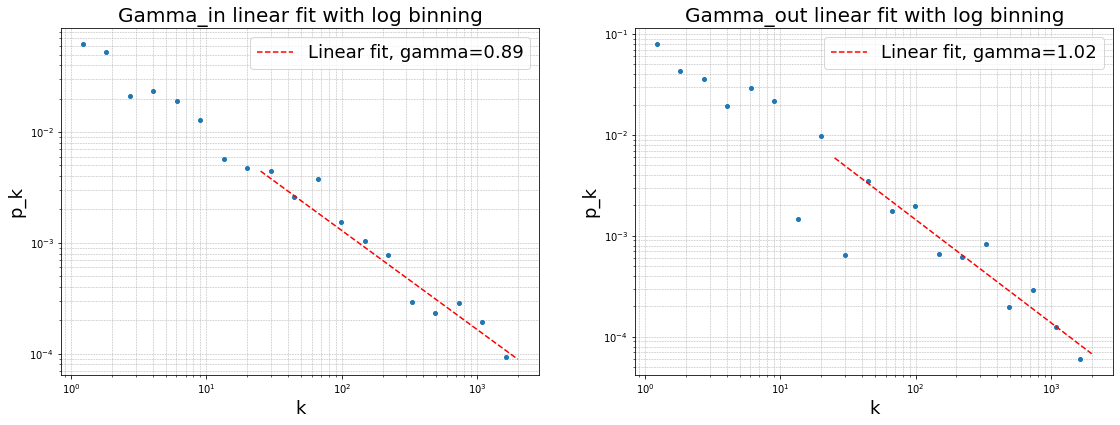

In [19]:
plt.figure(figsize=(60, 60))
plt.subplot(8, 6, 1)
plt.loglog(middle_bins, logbin_p_k_in , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_in linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_in[1])*x2**(-lin_gamma_in) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_in,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.subplot(8, 6, 2)
plt.loglog(middle_bins, logbin_p_k_out , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_out linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_out[1])*x2**(-lin_gamma_out) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_out,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.show()

### HITS (NetworkX)

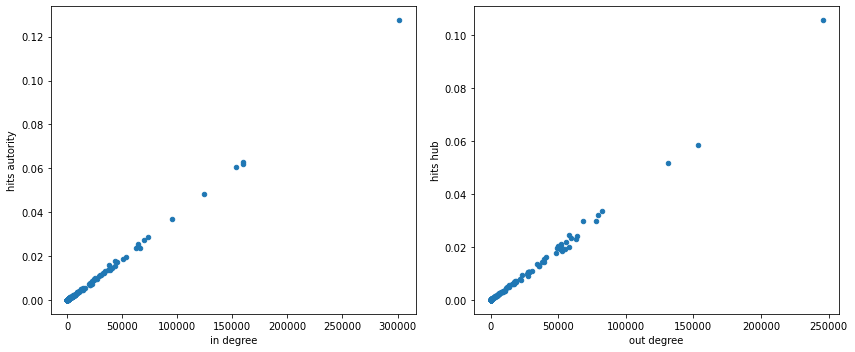

Top 10 for hits hub


,Nodes,hits hub
194,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.105405
48,UNIVERSITA DEGLI STUDI DI TORINO,0.058449
141,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.051489
47,UNIVERSITA DEGLI STUDI DI PADOVA,0.033370
52,UNIVERSITA DEGLI STUDI DI MILANO,0.031825
15,UNIVERSITA' DEGLI STUDI DI MILANO-BICOCCA,0.029831
184,POLITECNICO DI MILANO,0.029679
200,POLITECNICO DI TORINO,0.024470
112,UNIVERSITA DEGLI STUDI DI SASSARI,0.024036
119,UNIVERSITA DEGLI STUDI DI TRIESTE,0.023270


Top 10 for hits autority


,Nodes,hits autority
194,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.127436
47,UNIVERSITA DEGLI STUDI DI PADOVA,0.062870
184,POLITECNICO DI MILANO,0.062068
141,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.060527
219,UNIVERSITA DEGLI STUDI DI FIRENZE,0.048215
48,UNIVERSITA DEGLI STUDI DI TORINO,0.036840
158,UNIVERSITA COMMERCIALE LUIGI BOCCONI,0.028748
52,UNIVERSITA DEGLI STUDI DI MILANO,0.027372
77,UNIVERSITA DEGLI STUDI ROMA TRE,0.025541
125,UNIVERSITA DI PISA,0.024542


In [16]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

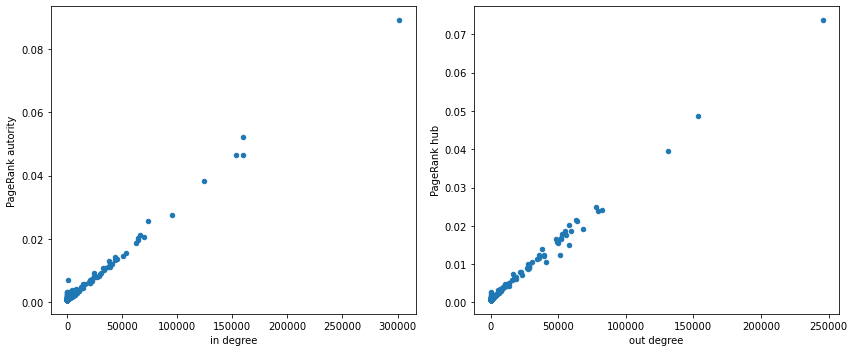

Top 10 for PageRank hub


,Nodes,PageRank hub
194,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.073620
48,UNIVERSITA DEGLI STUDI DI TORINO,0.048671
141,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.039597
15,UNIVERSITA' DEGLI STUDI DI MILANO-BICOCCA,0.024867
47,UNIVERSITA DEGLI STUDI DI PADOVA,0.024257
52,UNIVERSITA DEGLI STUDI DI MILANO,0.023997
234,UNIVERSITA DEGLI STUDI DI NAPOLI FEDERICO II,0.021579
112,UNIVERSITA DEGLI STUDI DI SASSARI,0.021314
5,UNIVERSITA DEGLI STUDI DI PALERMO,0.020312
184,POLITECNICO DI MILANO,0.019061


Top 10 for PageRank autority


,Nodes,PageRank autority
194,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.089071
184,POLITECNICO DI MILANO,0.052143
141,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.046395
47,UNIVERSITA DEGLI STUDI DI PADOVA,0.046374
219,UNIVERSITA DEGLI STUDI DI FIRENZE,0.038281
48,UNIVERSITA DEGLI STUDI DI TORINO,0.027461
158,UNIVERSITA COMMERCIALE LUIGI BOCCONI,0.025661
200,POLITECNICO DI TORINO,0.021383
52,UNIVERSITA DEGLI STUDI DI MILANO,0.020497
125,UNIVERSITA DI PISA,0.020148


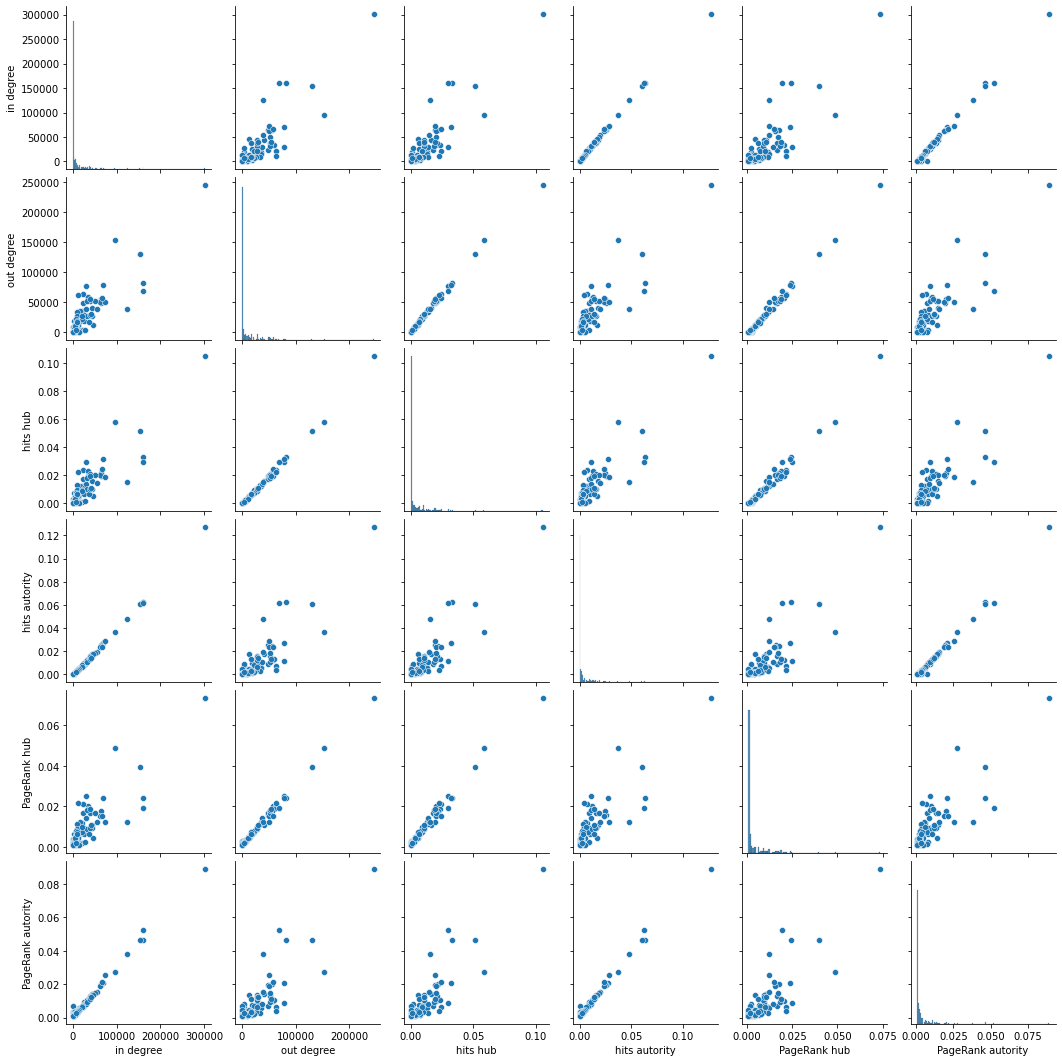

In [17]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')
# ci vuole troppo a farlo
sns.pairplot(scores[['in degree', 'out degree',  'hits hub',
       'hits autority', 'PageRank hub', 'PageRank autority']])
plt.show()
# from IPython.display import Image
# Image('pairplot_score.png',)

### Assortativity

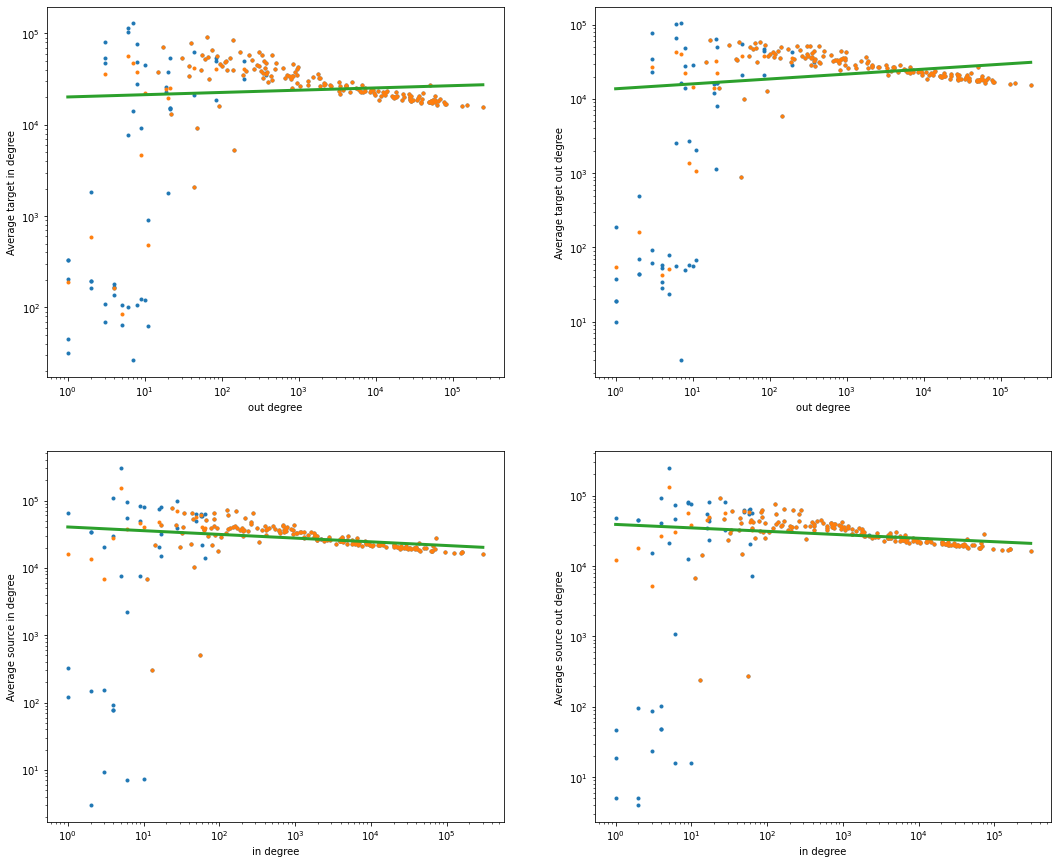

(0.024754664537987595,
 0.06605393866346729,
 -0.0550812750752602,
 -0.04910790590356632)

In [22]:
edges = mobility_df.copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)

### Robustness

In [25]:
#attack: removing hubs first
nodes_byhub = scores.sort_values('PageRank hub', ascending=False)['NodeID']
indices = list(nodes_byhub)
uni_df = mobility_df.copy()
GC_frac_a = [1]
for node in indices:
    uni_df = uni_df.loc[(uni_df['sourceID'] != node) & (uni_df['targetID'] != node)]
    temp_serie = uni_df.groupby(['sourceID', 'targetID']).sum()
    row = np.array(temp_serie.index.get_level_values(1).tolist())
    col = np.array(temp_serie.index.get_level_values(0).tolist())
    val = temp_serie.values
    temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(len(indices), len(indices)))
    GC_frac_a.append(ns.fraction_in_giant(temp_adj))


In [27]:
#random node removal
import random
#10 by 10, with average over 10 trials each time
intervals = list(range(10, len(nodes_byhub+1), 10))
uni_df = mobility_df.copy()
GC_frac_r = [1]
for i in intervals:
    i_GC_frac = []
    for j in range(10):
        removed = random.sample(indices, i)
        temp_df = uni_df.loc[~(uni_df['sourceID'].isin(removed) | (uni_df['targetID'].isin(removed)))]
        temp_serie = temp_df.groupby(['sourceID', 'targetID']).sum()
        row = np.array(temp_serie.index.get_level_values(1).tolist())
        col = np.array(temp_serie.index.get_level_values(0).tolist())
        val = temp_serie.values
        temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(len(indices), len(indices)))
        i_GC_frac.append(ns.fraction_in_giant(temp_adj))
    GC_frac_r.append(sum(i_GC_frac)/10)

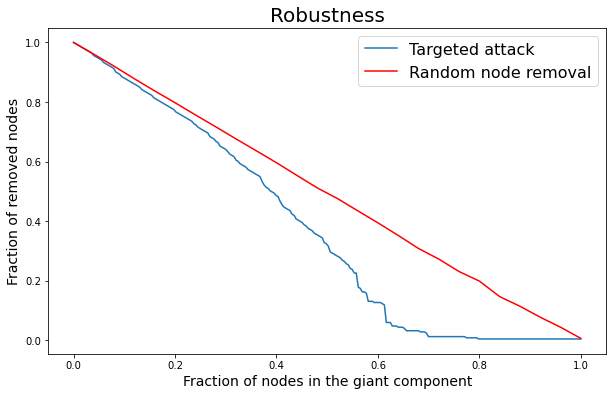

In [29]:
fig = plt.figure(figsize=(10,6))
plt.plot([i/len(nodes_byhub) for i in range(len(nodes_byhub)+1)], GC_frac_a, label='Targeted attack')
plt.plot([0]+[i/(len(intervals)*10) for i in intervals], GC_frac_r, 'r', label='Random node removal')
#plt.plot([0,1], [1,0], 'g', label='linear reference')
plt.xlabel('Fraction of nodes in the giant component', size=14)
plt.ylabel('Fraction of removed nodes', size=14)
plt.title('Robustness', size=20)
plt.legend(fontsize=16)
plt.show()

## Community detection

In [30]:
nodes_df

,Nodes,NodeID
0,"CONSERVATORIO STATALE DI MUSICA ""G.B. PERGOLES...",0
1,UNIVERSITÀ DEGLI STUDI INTERNAZIONALI DI ROMA,1
2,HUMANITAS UNIVERSITY,2
3,UNIVERSITA DEGLI STUDI DI UDINE,3
4,INSTITUTO SUPERIORE DI STDUDI MUSICALI - CONSE...,4
...,...,...
248,UNIVERSITA DEGLI STUDI DI PERUGIA,248
249,CONSERVATORIO DI MUSICA FRANCESCO VENEZZE,249
250,CONSERVATORIO DI MUSICA &QUOT;NINO ROTA&QUOT;,250
251,ACCADEMIA DI BELLE ARTI L'AQUILA,251


In [31]:
import networkx as nx

G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs, create_using= nx.DiGraph)
p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
node_comm = nodes_df.copy()
node_comm.drop(columns=['NodeID'], inplace=True)

node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
for i, set in enumerate(p):
    for element in set:
        node_comm.iat[element, 1]=i
for i, set in enumerate(p):
    display(node_comm[node_comm['Community']==i])
    
scores['Community'] = node_comm['Community']

,Nodes,Community
0,"CONSERVATORIO STATALE DI MUSICA ""G.B. PERGOLES...",0
2,HUMANITAS UNIVERSITY,0
4,INSTITUTO SUPERIORE DI STDUDI MUSICALI - CONSE...,0
5,SCUOLA NORMALE SUPERIORE,0
7,SIENA JAZZ - ACCADEMIA NAZIONALE DEL JAZZ,0
...,...,...
242,LUM JEAN MONNET,0
245,"CONSERVATORIO DI MUSICA ""G. P. DA PALESTRINA""",0
246,"ACCADEMIA DI BELLE ARTI ""LORENZO DA VITERBO""",0
249,CONSERVATORIO DI MUSICA FRANCESCO VENEZZE,0


,Nodes,Community
1,UNIVERSITÀ DEGLI STUDI INTERNAZIONALI DI ROMA,1
3,UNIVERSITA DEGLI STUDI DI UDINE,1
6,ISTITUTO SUPERIORE PER LE INDUSTRIE ARTISTICHE,1
11,LIBERA UNIVERSITA MARIA SS ASSUNTA,1
17,IED ISTITUTO EUROPEO DI DESIGN S.P.A.,1
...,...,...
240,ROME UNIVERSITY OF FINE ARTS,1
241,UNIVERSITÀ DEGLI STUDI EUROPEA,1
243,ACCADEMIA DI BELLE ARTI REGGIO CALABRIA,1
244,UNIVERSITA&APOS; DEGLI STUDI DI MILANO-BICOCCA,1


,Nodes,Community
8,UNIVERSITA DEGLI STUDI DI SASSARI,2
13,UNIVERSITA DEGLI STUDI DI PALERMO,2
28,UNIVERSITA' DEGLI STUDI DI SIENA,2
37,UNIVERSITA' DEGLI STUDI DI MILANO-BICOCCA,2
47,NUOVA SCUOLA EUROPEA SRL,2
...,...,...
237,SCUOLA SUPERIORE PER INTERPRETI E TRADUTTORI,2
238,ISTITUTO SUPERIORE DI STUDI MUSICALI DI REGGIO...,2
247,UNIVERSITA TELEMATICA E-CAMPUS,2
248,UNIVERSITA DEGLI STUDI DI PERUGIA,2


## Geographic plots

In [32]:
import geopandas as gpd

geo_df = gpd.read_file('countries.geojson')

def replace_iso2(alpha):
    try:
        return pc.countries.get(alpha_3=alpha).alpha_2
    except:
        return alpha
    
geo_df['iso2_code']= (np.array(list(map(lambda x: replace_iso2(x), geo_df['ISO_A3']))))

geo_df.columns = ['country', 'country_code', 'geometry', 'iso2_code']
geo_df = geo_df.loc[geo_df['country'] == 'Italy']

In [33]:
temp_df = uni_cities[['Receiving Organization', 'Receiving City']].copy()
temp_df.rename({'Receiving Organization':'Sending Organization', 'Receiving City':'Sending City'},axis=1, inplace=True)
cities_uni = pd.concat([uni_cities[['Sending Organization', 'Sending City']], temp_df]).drop_duplicates().reset_index(drop=True)
cities_uni.dropna(subset=['Sending City'], inplace=True)
cities_uni['Sending Organization'] = cities_uni['Sending Organization'].str.upper()
cities_uni = cities_uni.drop_duplicates().reset_index(drop=True)

# assigning cities to each university in scores
cities_list = []
for u in scores['Nodes']:
    cities_list.append(list(cities_uni.loc[cities_uni['Sending Organization'] == u, 'Sending City'])[0])
scores_cities = scores.copy()
scores_cities['City'] = cities_list

city_coord = pd.read_csv('worldcities.csv', encoding='utf8')
city_coord.drop(columns=['capital', 'population', 'id', 'iso3', 'country'], inplace=True)
city_coord = city_coord.loc[city_coord['iso2'] == 'IT']
for index in range(city_coord.shape[0]):
    city = city_coord.iat[index,0]
    if city != city.upper():
        city_coord.iat[index,0] = city.upper()
city_coord = city_coord.drop_duplicates().reset_index(drop=True)
scores_cities = pd.merge(left=scores_cities, right=city_coord, how='left', left_on='City', right_on='city')
scores_cities.dropna(subset=['city'], inplace=True)
scores_cities = scores_cities.drop_duplicates(subset='Nodes').reset_index(drop=True)
scores_cities
# some cities are missing

,Nodes,NodeID_x,in degree,out degree,NodeID_y,hits hub,hits autority,NodeID,PageRank hub,PageRank autority,Community,City,city,city_ascii,lat,lng,iso2,admin_name
0,HUMANITAS UNIVERSITY,2,50,0,2,0.000000e+00,0.000014,2,0.000697,0.000757,0,ROZZANO,ROZZANO,Rozzano,45.3833,9.1500,IT,Lombardy
1,UNIVERSITA DEGLI STUDI DI UDINE,3,8542,34431,3,1.347173e-02,0.003038,3,0.011378,0.002995,1,UDINE,UDINE,Udine,46.0667,13.2333,IT,Friuli-Venezia Giulia
2,INSTITUTO SUPERIORE DI STDUDI MUSICALI - CONSE...,4,17,1,4,8.494183e-10,0.000004,4,0.000702,0.000750,0,CUNEO,CUNEO,Cuneo,44.3833,7.5500,IT,Piedmont
3,SCUOLA NORMALE SUPERIORE,5,708,307,5,1.463846e-04,0.000323,5,0.000777,0.000968,0,PISA,PISA,Pisa,43.7167,10.4000,IT,Tuscany
4,UNIVERSITA DEGLI STUDI DI SASSARI,8,22348,64256,8,2.403580e-02,0.007280,8,0.021314,0.006657,2,SASSARI,SASSARI,Sassari,40.7267,8.5592,IT,Sardegna
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,UNIVERSITA DELLA VALLE D'AOSTA,234,618,958,234,2.232182e-04,0.000268,234,0.001161,0.000924,2,AOSTA,AOSTA,Aosta,45.7372,7.3206,IT,Valle d’Aosta
73,UNIVERSITA DEGLI STUDI DI MODENA E REGGIO EMILIA,235,28979,38395,235,1.414886e-02,0.010796,235,0.014090,0.008349,2,MODENA,MODENA,Modena,44.6458,10.9257,IT,Emilia-Romagna
74,CONSERVATORIO STATALE DI MUSICA A.STEFFANI,239,0,6,239,1.676031e-09,0.000000,239,0.000852,0.000746,0,CASTELFRANCO VENETO,CASTELFRANCO VENETO,Castelfranco Veneto,45.6667,11.9333,IT,Veneto
75,CONSERVATORIO DI MUSICA FRANCESCO VENEZZE,249,0,17,249,5.897880e-06,0.000000,249,0.000808,0.000746,0,ROVIGO,ROVIGO,Rovigo,45.0809,11.7940,IT,Veneto


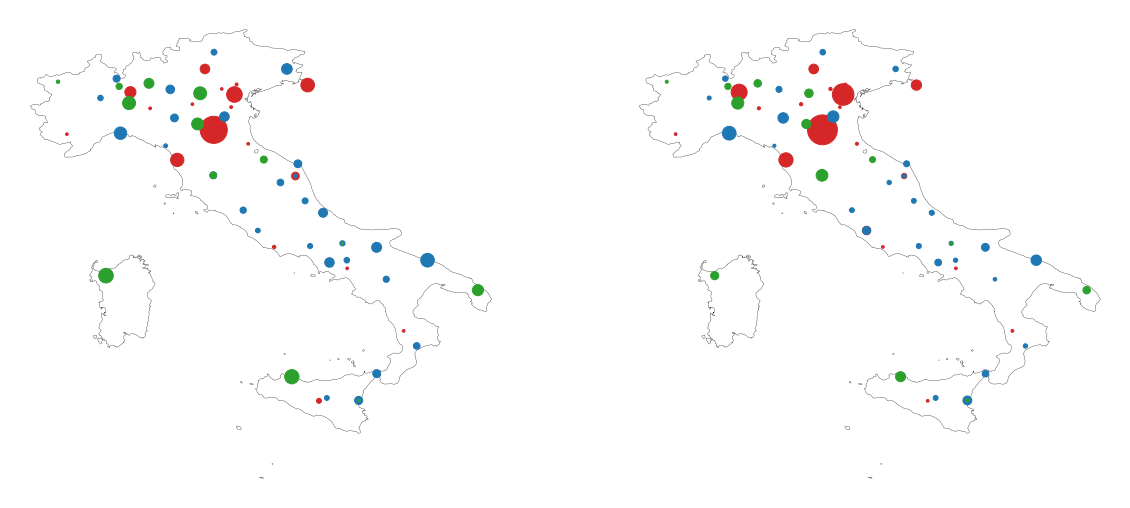

In [53]:
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:grey']
plt_list = ['PageRank hub', 'PageRank autority']

fig, ax = plt.subplots(1,2, figsize=(20,15))

for i in range(len(plt_list)):
    geo_df.plot(ax=ax[i], edgecolor='0', linewidth=0.3, color='1')
    for c in list(scores_cities['Community'].unique()):
        temp_df = scores_cities[scores_cities['Community'] == c].copy()
        ax[i].scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df[plt_list[i]]*10**4, color=colors[c])
    ax[i].axis('off')